In [1]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
nav = mda.units.N_Avogadro
    
import time
import gc
gc.collect()

17

In [2]:
path="/home/ricky/Documents/from_work/MD/simulations/production_run/data_for_FF_testing_Pavel/"
topology=path+"prod.tpr"
trajectory=path+"centered.xtc"
#for testing purposes to safe time for loading trajectory and creating dictonary
#the electron.dat will be decripted in the future as the values will be used from the universal mapping file
with open ('electrons.dat') as f:
    rawdata = f.read().split('\n')
    lines= rawdata[0:len(rawdata)-1]
    tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
    electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])

start_time=time.time()
u=mda.Universe(topology,trajectory)
print("Loading the trajectory in {} s".format(time.time()-start_time))
start_time=time.time()
wght=np.zeros(u.atoms.names.shape[0])
for i in range (0,u.atoms.names.shape[0]):
    wght[i]=electrons[u.atoms.names[i]]
    
print("Creating electron dictonary in {} s".format(time.time()-start_time))    

Loading the trajectory in 2.8395678997039795 s
Creating electron dictonary in 129.6760115623474 s


In [17]:
u.select_atoms("resname SOL")

<AtomGroup with 17280 atoms>

In [31]:
class FormFactor(object):
    """
    Calculates form factors from density profiles.
    
    Further development will include thickness of the membrane 
    from the intersection of lipid density and water density.
    Already enables to calculate electrom/mass/number densities
    
    Density could be calculated only from the final form factor profile 
    - testing is needed to see stability for rare species.
    
    Examination of FF error spikes is needed!
    
    """
    def __init__(self, conf,traj,nbin,bsize,output,center,group,density_type="electron"):
        path = "/home/ricky/Downloads/"
        self.conf = conf
        self.traj = traj
        start_time=time.time()
        self.uni = mda.Universe(self.conf,self.traj)
        
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))
        
        #group to calculate  mass or number densities - should be extended to more than 1 group!
        self.u = self.uni.select_atoms(group)
        
        
        #number of bins
        self.nbin = nbin
        #the totatl box size in [nm] - will be probably removed and tpr box size or 
        #transform of final FF will be used instead
        self.bsize = bsize
        self.output = output
        self.center = center
        
        self.density_type = density_type
        
        self.calculate_weight()
        

        self.calculate_density()
        
    def calculate_weight(self):
        """
        Creates an array of weights for all atoms in the simulation.
        
        For electron densities:
         - creates dictonary of atom types and number of electrons
           loaded form an external file --> in the future it backmaps 
                                            the atom names to mapping files
                                            and automaticaly assigns # of electrons
                                            
        Number densities:
         - all weights are 1
         
        Mass densities:
         - reads masses from u.atoms.masses
        """
        start_time=time.time()
        if self.density_type=="electron":
            with open ('electrons.dat') as f:
                rawdata = f.read().split('\n')
                lines= rawdata[0:len(rawdata)-1]
                tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
                electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        
            #weights to calculate the electron density
            wght=np.zeros(self.u.atoms.names.shape[0])
            for i in range (0,self.u.atoms.names.shape[0]):
                wght[i]=electrons[self.u.atoms.names[i]]
            self.wght=wght
        if self.density_type=="number":
            self.wght=np.ones(self.u.atoms.names.shape[0])
        if self.density_type=="mass":
            self.wght=self.u.atoms.masses * 10/6.02214076
            
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):

        
        c = self.uni.select_atoms(self.center)
        print(c)
        
        
        box_z = self.u.dimensions[2]
        d =  2*self.bsize/ self.nbin #     # bin width
        boxH = self.bsize
        z_center = np.linspace(-boxH,boxH,self.nbin+1)[:-1] + d/2
        z_no_center = np.linspace(-boxH,boxH,self.nbin+1)[:-1] + d/2
        density_z_center = np.zeros(self.nbin)
        density_z_no_center = np.zeros(self.nbin)
        fa=[]
        fb=[]

        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        min_z=10000000
        for ts in self.uni.trajectory:
            #count the index of the frame, numbered from 0, used to be used for the density profile averaging
            #posible not needed now
            frame = ts.frame
            
            #print(frame)
            

            
            #reads the dimension in z-direction
            box_z = ts.dimensions[2]
            if box_z/10<min_z:
                min_z=box_z/10
            
            #print(min_z)

            
            #reads the coordinates of all of the atoms
            crds = self.u.atoms.positions
            crds_no_center = self.u.atoms.positions[:,2]/10
            
            #calculates the center of mass of the selected atoms that the density should be centered around and 
            #takes the z-coordinate value
            ctom = c.atoms.center_of_mass()[2]
            
            #moves the center of mass of the selected centering group into box/2
            crds[:,2] += box_z/2 - ctom
            
            """shifts the coordinates in the universe by the value of the center of mass"""
            self.u.atoms.positions = crds
            
            """puts the atoms back to the original box dimension; it possibly does not take PBC into account
            #therefore it may brake some of the water molecules; try it, come to the issue later"""
            self.u.atoms.pack_into_box()
            
            """shif the coordinates so that the center in z-dimention is in 0; 
            #divide by 10 to get the coordinates in nm, since now the crds are only the z coordinates"""
            crds = (self.u.atoms.positions[:,2] - box_z/2)/10
            
            #gets the box-z size in nm
            box_z /= 10
            
            """calculates the volume of the bin; d- the "height" of a bin; assumes in [nm] """
            # ts.dimension[0], ts.dimension[1] - the x and y dimension; in [A] --> devides by 100
            vbin = d*np.prod(ts.dimensions[:2])/100
            
            #start_time2=time.time()

            """Runing FF - decrapted for now"""
            #d_ff =  box_z/ self.nbin
            #vbin_FF =d_ff*np.prod(ts.dimensions[:2])/100    
            #ff_density=np.histogram(crds,bins=self.nbin,range=(-box_z/2,box_z/2),weights=self.wght/vbin_FF)[0]
            
            FF_range = np.linspace(0,999,1000)  
            #fa_run,fb_run=self.fourier(ff_density,ts.dimensions[2]/10,FF_range,d_ff)
            
            #"""Do running ff - seems to produce consistent results"""
            #fourrier_result2= np.sqrt(np.multiply(fa_run,fa_run)+np.multiply(fb_run,fb_run))
            #fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
            #self.plot_fourier_final(fourrier_data2)

            
            #fa.append(fa_run)
            #fb.append(fb_run)
            #print("One furier loop takes {:10.6f} s".format(time.time()-start_time2))
          
            """Calculate and plot running densities"""
            #ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + box_z/(2*ff_density.shape[0])
            #data_density_ff=np.stack((ff_x,ff_density)).transpose()
            #self.plot_density(data_density_ff)
            #with open(str(self.output)+"running_density", 'wb') as f:
            #    np.savetxt(f, data_density_ff,fmt='%8.4f  %.8f')
         

            """calculates the total density profile; keep for now"""
            density_z_center += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.wght/vbin)[0]
            density_z_no_center += np.histogram(crds_no_center,bins=self.nbin,range=(-boxH,boxH),weights=self.wght/vbin)[0]
            #density_z_center += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.u.atoms.masses/vbin)[0]
        print("Calculating the density takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Normalizing the profiles """
        density_z_center /= (frame+1) 
        density_z_no_center /= (frame+1)
        

        """ Symmetrizing profile if necessary """
        #if args.symmetrize :
        #    density_z_center += density_z_center[::-1]
        #    density_z_center /=2


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Post-processign data and writing to file """
        density_data = np.vstack((z_center,density_z_center)).transpose()
        density_data_no_center = np.vstack((z_center,density_z_no_center)).transpose()
        
        
        """Post-processing of FF data from individual runs"""
        
        #fa_run = np.average(fa,axis=0)
        #fb_run = np.average(fb,axis=0)
        #fa_err = np.std(fa,axis=0)/np.sqrt(frame+1)
        #fb_err = np.std(fb,axis=0) /np.sqrt(frame+1)
        
        #fourrier_result= np.sqrt(np.multiply(fa_run,fa_run)+np.multiply(fb_run,fb_run))
        #calculate error (fa*fa_err + fb*fb_err)/ sqrt(fa^2+fb^2)
        #fourrier_error= np.multiply(1/(np.multiply(fa_run,fa_err)+np.multiply(fb_run,fb_err)),fourrier_result)
        #fourrier_data= np.vstack((FF_range*0.1*0.01,fourrier_result,fourrier_error)).transpose()
        
    
        
        
       
        """Get the indexes of the final density data where all the time steps contribute
        In other words, take the coordinates of the smalest box from the simulation"""
        final_FF_start=int(np.round(self.nbin/2-min_z/d/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/d/2))-1
        
  
        
        fa_aver, fb_aver = self.fourier(density_data[final_FF_start:final_FF_end,1],density_data[final_FF_end,0]-density_data[final_FF_start,0],FF_range,density_data[1,0]-density_data[0,0])
        
        """Plot density profiles from the average density with minimal box"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        fourrier_result2= np.sqrt(np.multiply(fa_aver,fa_aver)+np.multiply(fb_aver,fb_aver))
        fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
        #self.plot_fourier_final_run(fourrier_data,fourrier_data2)
        
        #print(fourrier_data)
        #print(fourrier_data2)

        with open(str(self.output)+".finalDensity", 'wb') as f:
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
        
        """Save data into files"""
        with open(self.output+".full_Density", 'wb') as f:
            np.savetxt(f, density_data,fmt='%8.4f  %.8f')
            
        with open(self.output+".full_Density_no_center", 'wb') as f:
            np.savetxt(f, density_data_no_center,fmt='%8.4f  %.8f')
            
        #with open(str(self.output)+".fourierFromEveryFrame", 'wb') as f:
        #    np.savetxt(f, fourrier_data,fmt='%8.4f  %.8f %.8f')
        
        with open(str(self.output)+".fourierFromFinalDensity", 'wb') as f:
            np.savetxt(f, fourrier_data2,fmt='%8.4f  %.8f')
  
        
        
    def plot_density(self,data):
        #data=np.loadtxt(self.output)
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        

    
    def plot_fourier_final(self,data):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    def plot_fourier_final_run(self,data,data2):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.errorbar(data[:,0],data[:,1],data[:,2])
        plt.plot(data2[:,0],data2[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    
    def fourier(self,ff_density,box_z,FF_range,d_ff):
        """Calculates fourier transform of ff_density in the FF_range"""
        #calculate a "height" of a bin for FF puroposes; in this case the number of bins is constant and the 
        #bin width changes
        
        
        """Creates the direct space coordinates"""
        #the calculations are stable with rounding (and others) errors in the direct space coordinates
        ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + box_z/(2*ff_density.shape[0])
        ff_x2 = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + d_ff/2
             
        
        k=0
        bulk=0
        while k*d_ff<0.33:
            bulk+=ff_density[k]+ff_density[-k-1]
            #print("The densities from the left and right ends are: {} {}".format(ff_density[k],ff_density[-k-1]))
            k+=1
        bulk/=(2*k)
        #print("The bulk density is {}".format(bulk))

            
        fa=np.zeros(FF_range.shape[0])
        fb=np.zeros(FF_range.shape[0])

        
        for j in range (0,ff_density.shape[0]):
            fa+=(ff_density[j]-bulk)*np.cos(FF_range*ff_x[j]*0.01)*d_ff
            fb+=(ff_density[j]-bulk)*np.sin(FF_range*ff_x[j]*0.01)*d_ff
            
 

        return fa, fb
 
               



Loading the trajectory takes   0.534877 s
Creating the electron mapping dictonary takes   0.001070 s
<AtomGroup [<Atom 1: N of type NTL of resname POPC, resid 0 and segid seg_0_POPC>, <Atom 2: C12 of type CTL2 of resname POPC, resid 0 and segid seg_0_POPC>, <Atom 3: H12A of type HL of resname POPC, resid 0 and segid seg_0_POPC>, ..., <Atom 34302: H16X of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>, <Atom 34303: H16Y of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>, <Atom 34304: H16Z of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>]>
Calculating the density takes  43.094796 s


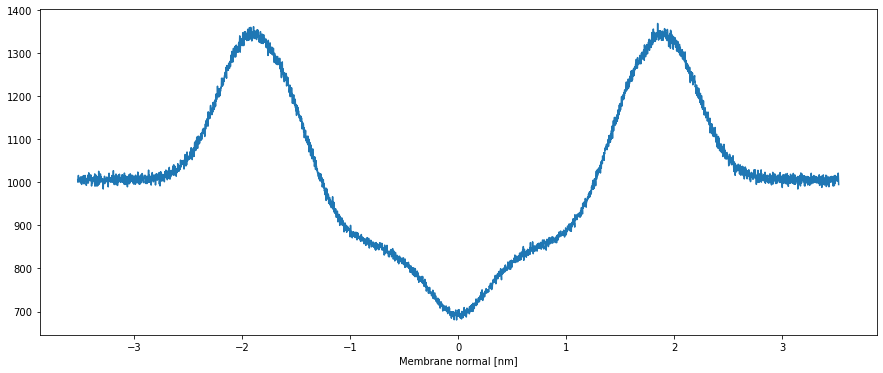

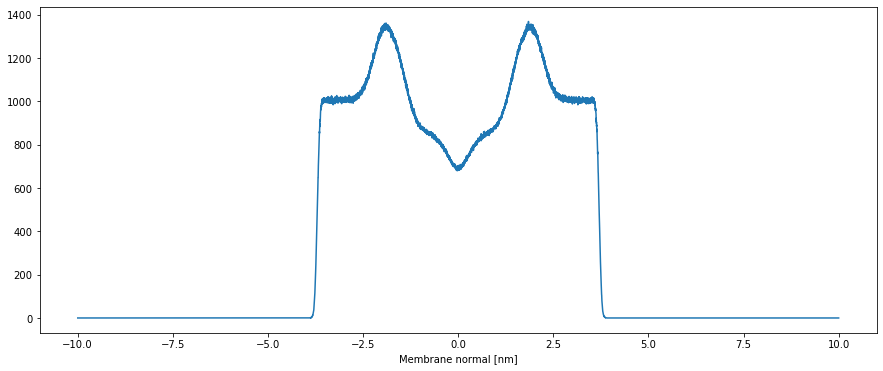

In [34]:
FormFactor(topology,trajectory,10000,10,'no_center_trajectory.Whole_system_Density_centered',"resname POPC","all","mass")

Loading the trajectory takes   1.103834 s
Creating the electron mapping dictonary takes   0.000942 s
<AtomGroup [<Atom 1: N of type NTL of resname POPC, resid 0 and segid seg_0_POPC>, <Atom 2: C12 of type CTL2 of resname POPC, resid 0 and segid seg_0_POPC>, <Atom 3: H12A of type HL of resname POPC, resid 0 and segid seg_0_POPC>, ..., <Atom 34302: H16X of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>, <Atom 34303: H16Y of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>, <Atom 34304: H16Z of type HAL3 of resname POPC, resid 255 and segid seg_0_POPC>]>
Calculating the density takes  32.080080 s


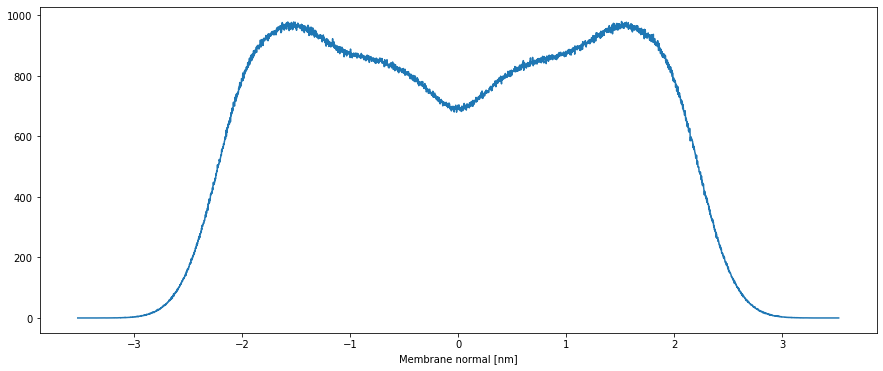

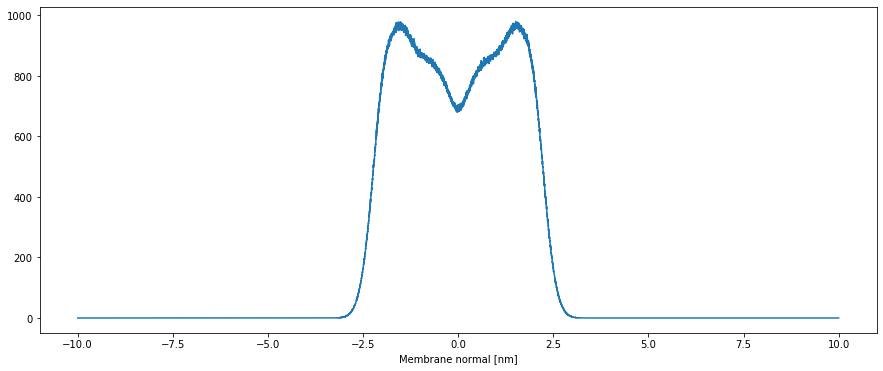

In [33]:
trajectory=path+"centered_new.xtc"
FormFactor(topology,trajectory,10000,10,'popc_convarge_with_Pavel_centered',"resname POPC","resname POPC","mass")

In [24]:
10**24

1000000000000000000000000

Loading the trajectory takes   0.514663 s
Calculating the density takes  64.779855 s


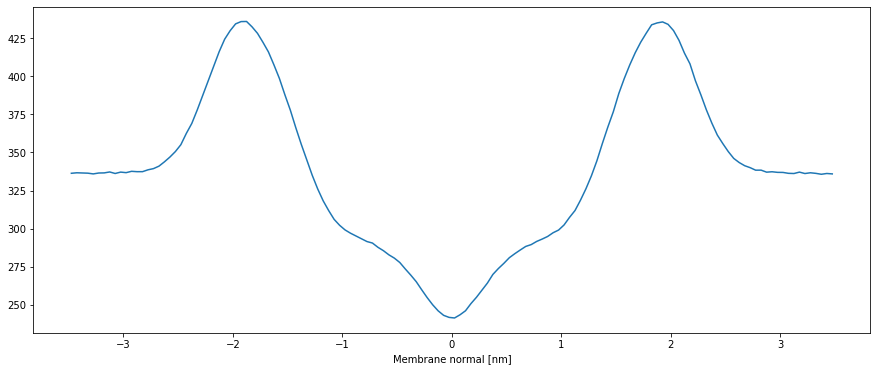

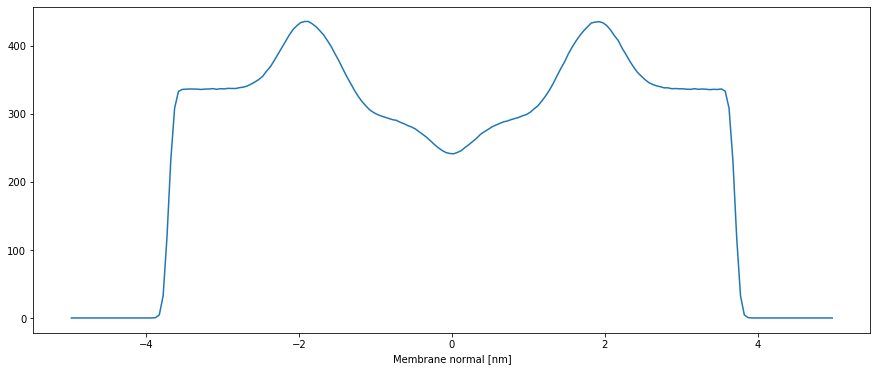

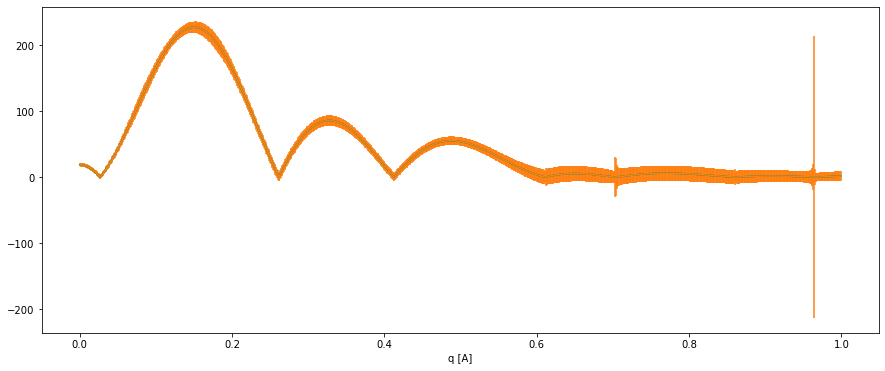

[[ 0.00000000e+00  1.90281507e+01  2.80499538e+00]
 [ 1.00000000e-03  1.90009298e+01  2.80556173e+00]
 [ 2.00000000e-03  1.89192792e+01  2.80726165e+00]
 ...
 [ 9.97000000e-01  1.49116080e+00 -7.44041347e+00]
 [ 9.98000000e-01  1.53337906e+00 -7.45102650e+00]
 [ 9.99000000e-01  1.57512155e+00 -7.46163515e+00]]
[[0.00000000e+00 1.84182773e+01]
 [1.00000000e-03 1.83911895e+01]
 [2.00000000e-03 1.83099382e+01]
 ...
 [9.97000000e-01 1.46580999e+00]
 [9.98000000e-01 1.50699045e+00]
 [9.99000000e-01 1.54773246e+00]]


In [84]:
#new format
FormFactor('pops_k.gro',"pops_k.xtc",200,5,'pops_k_test_density',"resname POPS","name P","number")
FormFactor('prod.tpr',"centered.xtc",200,5,'new_test_frame40')
